### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging



# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Used for making the graph to visualize our problem
# import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages
#logging.basicConfig(level=logging.DEBUG)
# turn off debug messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "L_w": 3.0 ,
    "C_b":0.85, 
    "c_year":1990,
    "current_year":None
}             

vessel = TransportResource(**data_vessel)

In [4]:
data_vessel

{'env': None,
 'name': 'Vessel M9',
 'route': None,
 'geometry': None,
 'v': None,
 'type': None,
 'B': 11.45,
 'L': 135,
 'H_e': None,
 'H_f': None,
 'T': 2.75,
 'P_installed': 2200.0,
 'P_tot_given': None,
 'L_w': 3.0,
 'C_b': 0.85,
 'c_year': 1990,
 'current_year': None}

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s    = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0    = [10, 7.5, 5, 3.5]                 # water depths,(m)
c_year = [1970,1980,1990,2000,2010,2020]   # engine construction years

### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(c_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"c_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(400)

,c_year,h_0,V_s
0,1970,10.0,0.100000
1,1970,10.0,0.139698
2,1970,10.0,0.179397
3,1970,10.0,0.219095
4,1970,10.0,0.258794
...,...,...,...
395,1970,7.5,7.841206
396,1970,7.5,7.880905
397,1970,7.5,7.920603
398,1970,7.5,7.960302


In [7]:
# # make a function that does all the work
# def do_simulation(row):
#     time.sleep(0.0001)
#     f'running simulation for {row.c_year}, {row.h_0}, {row.V_s}'
#     return row.c_year

# # test the function on 1 row
# row = work_df.iloc[0]
# do_simulation(row)


In [8]:
# # apply (from map, reduce approach) the function to all the work
# # show the rpogress
# tqdm.tqdm.pandas(desc="running simulations")
# # do the apply
# results = work_df.progress_apply(do_simulation, axis=1)

In [9]:
# # show the results
# results.head()

In [10]:
# This is one way to do it, instantiate a ConsumesEnergy class
# At the moment this does not work on it's own, because the formula's depend on L from the general vessel properties
# L is defined in VesselProperties
energy_vessel = opentnsim.core.ConsumesEnergy(
    P_installed=data_vessel["P_installed"],
    L_w=data_vessel["L_w"],
    C_b=data_vessel["C_b"],
    current_year=data_vessel["current_year"],

     c_year=row['c_year']
)
   # c_year=data_vessel["c_year"]
# make a list for collecting results 
results = []

for i, row in work_df.iterrows():
    # create a new vessel, like the one above (so that it also has L)
    vessel = TransportResource(**data_vessel)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    c_year=row['c_year']
    vessel.calculate_properties() # L is used here in the computation of L_R
    
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required()
    vessel.emission_factors_general()
    vessel.correction_factors()
    vessel.calculate_emission_factors_total()
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    
    
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_m'] = Fuel_g_m/3600
    result['emission_g_m_CO2']=emission_g_m_CO2/3600
    result['emission_g_m_PM10']=emission_g_m_PM10/3600
    result['emission_g_m_NOX']=emission_g_m_NOX/3600
    results.append(result)

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the engine is 1990
The construction year of the eng

In [11]:
plot_df = pd.DataFrame(results)
plot_df

,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_m,emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX
0,0.034195,0.003647,1.023630e-78,0.012007,0.049849,110.009309,302524.780381,959828.621390,1073.660692,20332.559836
1,0.062944,0.006714,2.583309e-57,0.023392,0.093049,110.024274,216584.024868,687162.042537,768.625511,14556.051864
2,0.099453,0.010608,5.015575e-45,0.038507,0.148568,110.049772,168694.301060,535221.009728,598.630149,11336.887838
3,0.143433,0.015299,5.186162e-37,0.057335,0.216066,110.088402,138175.065556,438391.798899,490.277646,9285.112151
4,0.194666,0.020764,2.363542e-31,0.079854,0.295284,110.142704,117035.130677,371320.550968,415.206671,7863.631583
...,...,...,...,...,...,...,...,...,...,...
4795,133.454348,14.234659,8.018179e+02,92.835083,1042.342018,2200.000000,62959.702640,199753.965650,108.860805,2748.735324
4796,134.712027,14.368807,7.888527e+02,92.896334,1030.829902,2200.000000,62642.555633,198747.744692,108.312440,2734.889116
4797,135.975191,14.503540,7.764335e+02,92.945138,1019.857349,2200.000000,62328.587743,197751.610202,107.769572,2721.181703
4798,137.243838,14.638858,7.645681e+02,92.982295,1009.433125,2200.000000,62017.751405,196765.411275,107.232119,2707.611009


### Run OpenTNSim to Calculate resistance, required power and emissions 
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

### Figures output

### Figure 3: Components of the total resistance

In [12]:
V_s    = np.linspace(0.1, 8, 200)
V_s_km = V_s * 3.6
len(V_s_km)

200

Text(0.5, 1.05, 'M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, h$_0$ = 7.5 m')

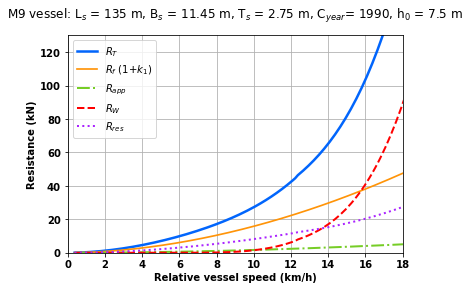

In [13]:
# resistance for water depth h2 = 7.5 m, 1990
V_s    = np.linspace(0.1, 8, 200)
V_s_km = V_s * 3.6

plt.figure(figsize=(6,4))
plt.plot(V_s_km, plot_df['R_T'][1800:2000],color='#0165fc', linewidth = 2.5)       # RT, total resistance of the ship,[kN] 
plt.plot(V_s_km, plot_df['R_f_one_k1'][1800:2000],color='#ff9408', linewidth = 1.7) # Rf(1+k1), frictional resistance including the hull form factor
plt.plot(V_s_km, plot_df['R_APP'][1800:2000],'-.', color='#76cd26',linewidth = 2)   # Rapp, appendage resistance
plt.plot(V_s_km, plot_df['R_W'][1800:2000], 'r--', linewidth = 2)                   # Rw, wave resistance
plt.plot(V_s_km, plot_df['R_res'][1800:2000],':',color='#aa23ff', linewidth = 2) # Rres, residual resistance
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 130)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')


#plt.savefig('resistance components.pdf', dpi=600, format='pdf') 
plt.savefig('PartIV-05-04.eps', dpi=600, format='eps') 
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, h$_0$ = 7.5 m',y=1.05)

### Figure 5: Total required power

Text(0.5, 1.05, 'M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990')

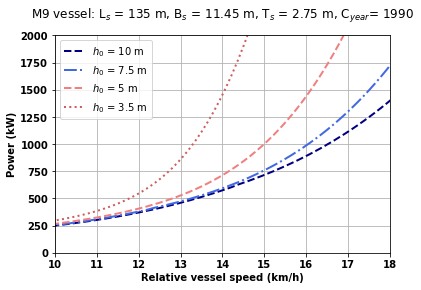

In [14]:
plt.figure(figsize = (6,4))
plt.plot(V_s_km, plot_df['P_tot'][1600:1800],'--', color='navy',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][1800:2000],'-.', color='royalblue',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][2000:2200],'--', color='lightcoral',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][2200:2400],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'])

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('total power required versus speed with diff water depths.pdf', dpi=600, format='pdf') 
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990',y=1.05)

### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5)

Text(0.5, 1.05, 'M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990')

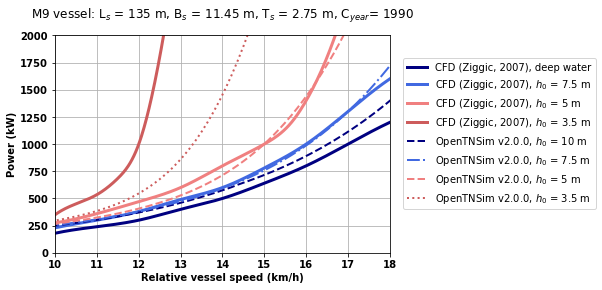

In [15]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)


plt.plot(V_s_km, plot_df['P_tot'][1600:1800],'--', color='navy',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][1800:2000],'-.', color='royalblue',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][2000:2200],'--', color='lightcoral',linewidth = 2.0)
plt.plot(V_s_km, plot_df['P_tot'][2200:2400],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
            'OpenTNSim v2.0.0, $h_0$ = 10 m', 'OpenTNSim v2.0.0, $h_0$ = 7.5 m', 'OpenTNSim v2.0.0, $h_0$ = 5 m', 'OpenTNSim v2.0.0, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('validation_total power required versus speed with diff water depths.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990',y=1.05)

### Figure 8: Emissions as a function of vessel speed: emission rates in g/km versus speed for different water depths

In [17]:
#to do: lines broken when power > installed. 'and' power2v 

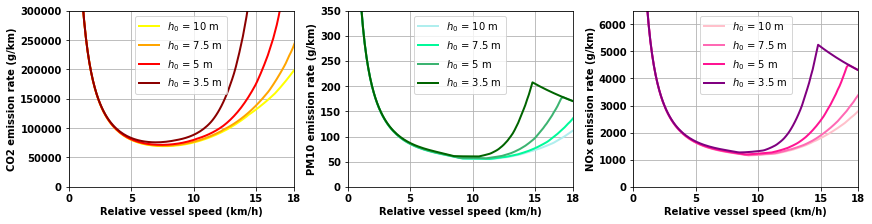

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
plt.plot(V_s_km, plot_df['emission_g_m_CO2'][1600:1800], 'yellow',linewidth = 2.0) # CO2 emission rates for water depth h1=10 m
plt.plot(V_s_km, plot_df['emission_g_m_CO2'][1800:2000], 'orange',linewidth = 2.0) # CO2 emission rates for water depth h2=7.5 m
plt.plot(V_s_km, plot_df['emission_g_m_CO2'][2000:2200], 'red',linewidth = 2.0)    # CO2 emission rates for water depth h3=5 m
plt.plot(V_s_km, plot_df['emission_g_m_CO2'][2200:2400], 'darkred',linewidth = 2.0)
# for water depth h4=3.5 m, speed limited to 15.6 km/h
# plt.plot(V_s_km[V_0_km<15.6], emission_g_m_CO2_4[V_0_km<15.6], 'darkred',linewidth = 2.0) 

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 300000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
plt.plot(V_s_km, plot_df['emission_g_m_PM10'][1600:1800], 'paleturquoise',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_PM10'][1800:2000], 'mediumspringgreen',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_PM10'][2000:2200], 'mediumseagreen',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_PM10'][2200:2400], 'darkgreen',linewidth = 2.0)
#plt.plot(V_s_km[V_0_km<15.6], emission_g_m_PM10_4[V_0_km<15.6], 'darkgreen',linewidth = 2.0)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 350)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(133)
plt.plot(V_s_km, plot_df['emission_g_m_NOX'][1600:1800], 'pink',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_NOX'][1800:2000], 'hotpink',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_NOX'][2000:2200], 'deeppink',linewidth = 2.0)
plt.plot(V_s_km, plot_df['emission_g_m_NOX'][2200:2400], 'purple',linewidth = 2.0)
#plt.plot(V_s_km[V_0_km<15.6], emission_g_m_NOX_4[V_0_km<15.6], 'purple',linewidth = 2.0)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6500)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

#plt.savefig('emission rates versus speed with diff water depth.pdf', dpi=600, format='pdf')  
plt.savefig('PartIV-05-09.eps', dpi=600, format='eps') 

### Figure 9: Emissions as a function of engine age: emission rates in g/km versus speed for different engine ages


In [ ]:
to do: c_years 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
plt.plot(V_0_km, emission_g_m_CO2_11, 'darkred',linewidth = 2.0)   # CO2 emission rates for engine construction year 1970
plt.plot(V_0_km, emission_g_m_CO2_22, 'red',linewidth = 2.0)       # CO2 emission rates for engine construction year 1980
plt.plot(V_0_km, emission_g_m_CO2_33, 'darkorange',linewidth = 2.0)# CO2 emission rates for engine construction year 1990
plt.plot(V_0_km, emission_g_m_CO2_44, 'orange',linewidth = 2.0)    # CO2 emission rates for engine construction year 2000
plt.plot(V_0_km, emission_g_m_CO2_55, 'gold',linewidth = 2.0)      # CO2 emission rates for engine construction year 2010
plt.plot(V_0_km, emission_g_m_CO2_66, 'yellow',linewidth = 2.0)    # CO2 emission rates for engine construction year 2020
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
plt.plot(V_0_km, emission_g_m_PM10_11, 'darkgreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_22, 'seagreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_33, 'mediumseagreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_44, 'mediumspringgreen')
plt.plot(V_0_km, emission_g_m_PM10_55, 'aquamarine',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_66, 'paleturquoise',linewidth = 2.0)
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(133)
plt.plot(V_0_km, emission_g_m_NOX_11, 'purple',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_22, 'darkmagenta',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_33, 'orchid',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_44, 'deeppink',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_55, 'hotpink',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_66, 'pink',linewidth = 2.0)
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

#plt.savefig('emission rates versus speed with diff engine ages.pdf', dpi=600, format='pdf')
plt.savefig('PartIV-05-10.eps', dpi=600, format='eps')
#fig.suptitle('Emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m, h = 10 m)')